In [7]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
import keras.optimizers as ko
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow
import torch
import cv2
import os
import copy
%matplotlib inline

In [28]:
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images

detect: weights=['yolov5s.pt'], source=data/images, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-215-ga6659d0 Python-3.8.8 torch-2.0.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/2 D:\personal_project\yolov5\data\images\bus.jpg: 640x480 4 persons, 1 bus, 434.9ms
image 2/2 D:\personal_project\yolov5\data\images\zidane.jpg: 384x640 2 persons, 2 ties, 274.8ms
Speed: 3.0ms pre-process, 354.8ms inference, 9.2ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs\detect\exp3


In [5]:
yolo_model = torch.hub.load("ultralytics/yolov5","custom","yolov5s.pt")

Using cache found in C:\Users\Hp/.cache\torch\hub\ultralytics_yolov5_master
requirements: Ultralytics requirement ['setuptools>=65.5.1'] not found, attempting AutoUpdate...
requirements:  AutoUpdate skipped (offline)
YOLOv5  2023-6-9 Python-3.8.8 torch-2.0.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [30]:
temp = cv2.imread('D:\\personal_project\\test_1.jpg')
image = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
duplicate = copy.copy(image)
%matplotlib inline

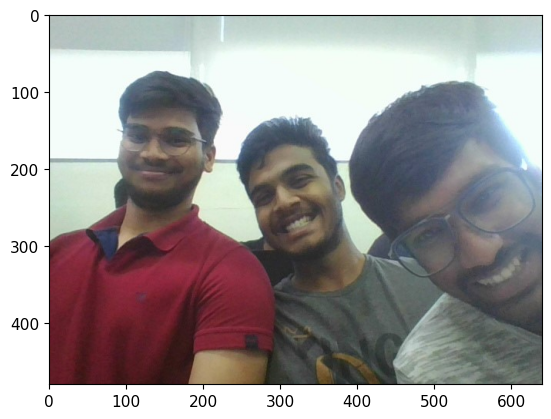

In [9]:
plt.imshow(image)
plt.show()

# Checking on heading

In [2]:
## function to crop out results from the images from results of YOLO algorithm
def crop(results,image):
  cropped = []
  w = image.shape[1]
  h = image.shape[0]
  for result in results[0]:
    if int(result[5]) == 0:
      x1 = int((result[0]-(result[2]/2))*w)
      y1 = int((result[1]-(result[3]/2))*h)
      x2 = int((result[0]+(result[2]/2))*w)
      y2 = int((result[1]+(result[3]/2))*h)
      cropped.append(image[y1:y2,x1:x2,:])
  return cropped

## function to blur the particular section
def blur_section(cropped):
  blurred = []
  for section in cropped:
    blurred.append(cv2.blur(section,(20,20)))
  return blurred

## Inserting back the blurred face into the part 
def back(results,image,blurred):
  w = image.shape[1]
  h = image.shape[0]
  i = 0
  for result in results[0]:
    if int(result[5]) == 0:
      x1 = int((result[0]-(result[2]/2))*w)
      y1 = int((result[1]-(result[3]/2))*h)
      x2 = int((result[0]+(result[2]/2))*w)
      y2 = int((result[1]+(result[3]/2))*h)
      image[y1:y2,x1:x2,:] = blurred[i]
      i+=1
  return image

In [3]:
## to get the final image with all the operations done
def generateBlurred(image,model):
  duplicate = copy.copy(image)
  final_image = copy.copy(image)
  results = model(duplicate)
  cropped = crop(results.xywhn,final_image)
  blurred = blur_section(cropped)
  final = back(results.xywhn,final_image,blurred)

  return final_image

# Blurring image

In [12]:
final_image = generateBlurred(image,yolo_model)

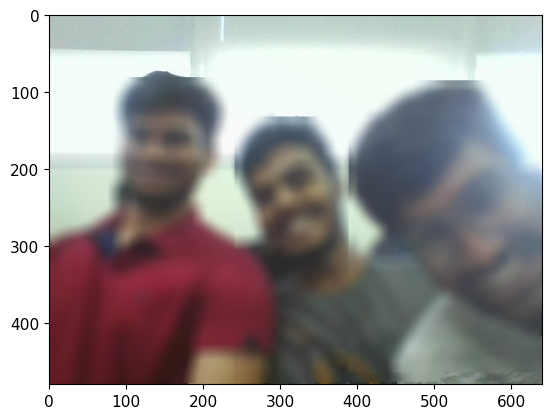

In [13]:
plt.imshow(final_image)

In [8]:
# Real time video test

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    newframe = generateBlurred(frame,yolo_model)
    cv2.imshow('frame', newframe)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# video capture

In [15]:
cap  = cv2.VideoCapture("ppl_running.mp4")

In [22]:
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
fcount = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)

In [17]:
fcount/fps

7.24

In [5]:
# checking the reader

while cap.isOpened():
    ret, frame = cap.read()
         # if frame is read correctly ret is True
    if not ret:
      print("Can't receive frame (stream end?). Exiting ...")
      break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.namedWindow('hello', cv2.WINDOW_NORMAL)
    cv2.imshow('hello',gray)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Modifying and writing video

In [24]:
filename = "new.avi"
video_writer = cv2.VideoWriter(os.path.join(filename),cv2.VideoWriter_fourcc('P','I','M','1'),fps,(width,height))

In [34]:
while cap.isOpened():
    ret, frame = cap.read()
         # if frame is read correctly ret is True
    if not ret:
      print("Can't receive frame (stream end?). Exiting ...")
      break

    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    #cv2.namedWindow('hello', cv2.WINDOW_NORMAL)
    #cv2.imshow('hello',image)
    final_image = generateBlurred(image,yolo_model)
    video_writer.write(final_image)
    
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

video_writer.release()
cap.release()
cv2.destroyAllWindows()

Can't receive frame (stream end?). Exiting ...


#  Deep Face

In [4]:
from deepface import DeepFace
from deepface.commons import functions

In [8]:
model_name = "VGG-Face"

target_size = functions.find_target_size(model_name = model_name)
 
img1 = DeepFace.extract_faces(img_path = "test_1.jpg", target_size=target_size, detector_backend ="mtcnn")
 
img1 = np.expand_dims(img1, axis=0) #(224, 224, 3) to (1, 224, 224, 3)

1/1 [==============================] - 0s 55ms/step


In [9]:
img1.shape[1]

2

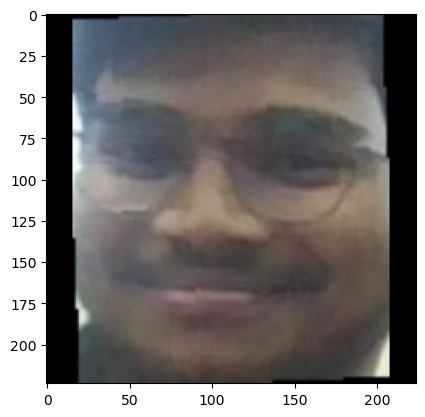

In [10]:
plt.imshow(img1[0][0]['face'])

In [24]:
## function to extracted results as [x,y,w,h] from the processed results
def extractResults(processed):
    results = []
    n = processed.shape[1]
    
    for i in range(n):
        x = processed[0][i]['facial_area']['x']
        y = processed[0][i]['facial_area']['y']
        w = processed[0][i]['facial_area']['w']
        h = processed[0][i]['facial_area']['h']
        results.append([x,y,w,h])
    return results

## function to extract faces as 240x240px from the results
def extractFaces(processed):
  faces = []
  n = processed.shape[1]
  for i in range(n):
    faces.append(processed[0][i]['face'])
  return faces


## function to get faces from the [x,y,w,h] results    
def getFaces(results,image):
  cropped = []
  w = image.shape[1]
  h = image.shape[0]
  for result in results:
      x1 = result[0]
      y1 = result[1]
      x2 = result[0] + result[2]
      y2 = result[1] + result[3]
      cropped.append(image[y1:y2,x1:x2,:])
  return cropped

In [13]:
## extracting the faces and results from the processed frame
results = extractResults(img1)
faces = extractFaces(img1)

In [14]:
model = DeepFace.build_model(model_name = model_name)

In [15]:
newimg1 = np.expand_dims(faces[0], axis=0)
newimg2 = np.expand_dims(faces[1], axis=0)

In [16]:
## converting the predicted from np.array to list

img1_representation = model.predict(newimg1).tolist()
img2_representation = model.predict(newimg2).tolist()

1/1 [==============================] - 0s 247ms/step


In [17]:
distance_vector = np.square(np.array(img1_representation) - np.array(img2_representation)) #getting distance from representation
distance = np.sqrt(distance_vector.sum())

In [18]:
distance

0.41981819341462656

In [22]:
img2 = DeepFace.extract_faces(img_path = "test_2.jpg", target_size=target_size, detector_backend ="mtcnn")

img2 = np.expand_dims(img2, axis=0) #(224, 224, 3) to (1, 224, 224, 3)

1/1 [==============================] - 0s 57ms/step


In [25]:
results2 = extractResults(img2)
faces2 = extractFaces(img2)

In [170]:
compare_1 = np.expand_dims(faces2[2], axis=0)
compare_2 = np.expand_dims(faces2[3], axis=0)

In [36]:
## to get the euclidean distancefor image comparison
def euclidDist(img1_representation,img2_representation):
  distance_vector = np.square(np.array(img1_representation) - np.array(img2_representation)) #getting distance from representation
  distance = np.sqrt(distance_vector.sum())
  return distance

## Comparing the faces and drawing the final conclusion
def compareFaces(image1,image2,model):
  img1_representation = model.predict(image1).tolist()
  img2_representation = model.predict(image2).tolist()
  if euclidDist(img1_representation,img2_representation) <=0.55:
    return True
  return False

In [171]:
euclidDist(img1_representation,img2_representation)
compareFaces(compare_1,compare_2,model)

1/1 [==============================] - 0s 242ms/step


True

In [185]:
model_name = "VGG-Face"
target_size = functions.find_target_size(model_name = model_name)
model = DeepFace.build_model(model_name = model_name)

## Getting the unique faces in the image and store them in a list

def getUnique(uniqueFaces,image,model):
    facedata = []
    # getting the results as faces from the detector
    initial_results = DeepFace.extract_faces(image, target_size=target_size, detector_backend ="mtcnn")
    initial_results = np.expand_dims(initial_results, axis=0)
    
    #extracting the different results
    results = extractResults(initial_results)
    faces = extractFaces(initial_results)
    
    # comparing the faces to the faces already in the list
    i = 0 
    for frameFace in faces:
        frameFace = np.expand_dims(frameFace, axis=0)
        if len(uniqueFaces) == 0:
            uniqueFaces.append(frameFace[0])
            facedata.append([0,results[i]]) #facedata[0].append(results[i]) #
            
        else: 
            check = True
            j = 0
            for existingFace in uniqueFaces:
                existingFace = np.expand_dims(existingFace, axis=0)
                #j+=1
                if check and compareFaces(frameFace,existingFace,model):
                    check = False
                    facedata.append([j,results[i]]) #facedata[j].append(results[i])
                    break
                j=j+1 
                
            if check:
                uniqueFaces.append(frameFace[0])
                facedata.append([j,results[i]]) #facedata[j].append(results[i]) 
        
        i= i+1
        
    return facedata
    

In [186]:
temp = cv2.imread('D:\\personal_project\\test_1.jpg')
image1 = temp#cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
temp = cv2.imread('D:\\personal_project\\test_2.jpg')
image2 = temp#cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)

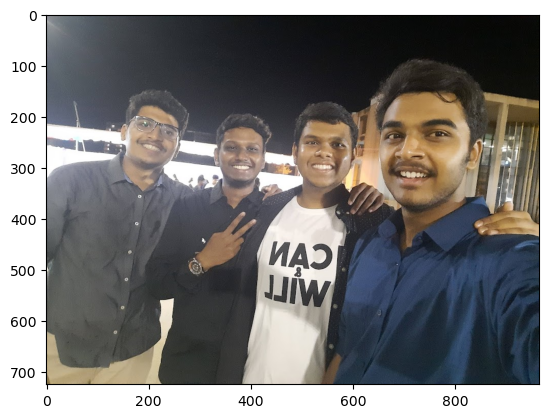

In [47]:
plt.imshow(image2)

In [187]:
uniqueFaces = []
first = getUnique(uniqueFaces,image1,model)
second = getUnique(uniqueFaces,image2,model)

1/1 [==============================] - 0s 191ms/step


In [159]:
second

[[1, [339, 226, 82, 102]],
 [2, [491, 205, 99, 130]],
 [3, [157, 176, 101, 122]],
 [3, [652, 149, 176, 226]]]

In [158]:
len(uniqueFaces)

4

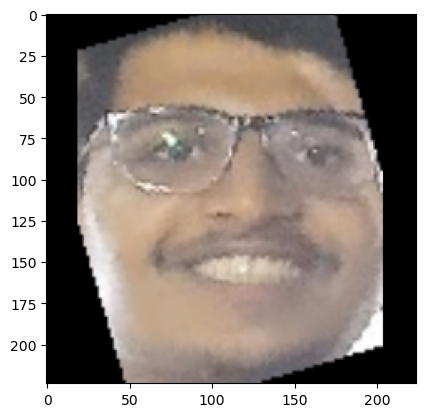

In [167]:
plt.imshow(uniqueFaces[3])

# Integration for Video

In [173]:
video_file = "ppl_running.mp4"
filename = "new.avi"
uniqueFaces = []

model_name = "VGG-Face"
target_size = functions.find_target_size(model_name = model_name)
model = DeepFace.build_model(model_name = model_name)

# start reading the video

# get the unique faces from original frame store them

# display unique faces and assign them a number for each frame like hash table

# choose faces to not be blurred and blur others out of each frame

# construct back the video from the obtained images in the pandas frame

In [174]:
# starting cap and video writer
cap  = cv2.VideoCapture(video_file)

height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
fcount = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)


video_writer = cv2.VideoWriter(os.path.join(filename),cv2.VideoWriter_fourcc('P','I','M','1'),fps,(width,height))

In [191]:
newFrames = []
i = 0

while cap.isOpened():
    ret, frame = cap.read()
         # if frame is read correctly ret is True
    if not ret:
      print("Can't receive frame (stream end?). Exiting ...")
      break
    
    if i%5 == 0:
        newData = getUnique(uniqueFaces,frame,model)
        newFrames.append([frame,newData])
    i+=1
    print(i)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 460ms/step
1
2
3
4
5
1/1 [==============================] - 0s 452ms/step


KeyboardInterrupt: 

In [ ]:
for data in newFrames:
    frame,newData = data
    
    #modify the frame according to the user requirement
    # to do....
    #
    
    video_writer.write(frame)
    
video_writer.release()